# Bellabeat Case Study Project
*by Daria Yuferova*

## Case Scenario Description

__Bellabeat__ is a high-tech manufacturer of health-focused products for women. It is a successful small company, but they have the potential to become a larger player in the global smart device market. The executive management believes that analyzing smart device fitness data could help unlock new growth opportunities for the company. To make this happen, a new marketing strategy needs to be built based on non-Bellabeat smart devices data analysis made by an analytical team.

Thus, the business task for this case study states as follows: __to inform a data-driven decision of the executive team on future marketing strategy, we need to explore how consumers are using their smart devices and how the company can leverage those insights.__

The following report will cover the process of end-to-end data analysis, starting with extracting data from public datasets, cleaning and transforming data, analyzing it, ending with visualizing the results and making recommendations.

## STEP 1. Collecting Data

First of all, we need to import all the necessary packages:

In [1]:
install.packages('tidyverse') # to handle dataframes
install.packages('janitor') # to better clean data
install.packages('lubridate') # to better handle datetime values
install.packages('ggplot2') # to create visualizations
install.packages('scales') # to better handle visalizations
install.packages('ggridges') # to create ridgeplots
install.packages('patchwork') # to display several plots
install.packages('ggpubr') # to add customized elements to plots

In [ ]:
library('tidyverse')
library('janitor')
library('lubridate')
library('scales')
library('ggridges')
library('patchwork')
library('ggpubr')

We then need to upload the dataset.   
It is an open source dataset generated by respondents to a distributed survey via Amazon Mechanical Turk between 03.12.2016-05.12.2016. Thirty eligible Fitbit users consented to the submission of personal tracker data, including minute-level output for physical activity, heart rate, and sleep monitoring.
Dataset was provided by MÖBIUS and is accessible on [Kaggle](https://www.kaggle.com/datasets/arashnic/fitbit).  
We don't have any demographic data on the respondents, and we cannot confirm unbiased sampling, so this should be kept in mind during analysis.

Let's read all the files we're going to use in this analysis and make sure column names are consistent:

In [ ]:
daily_activity <- read_csv('../data/dailyActivity_merged.csv') %>%
  clean_names()
  
daily_sleep <- read_csv('../data/sleepDay_merged.csv') %>%
  clean_names()

hourly_intensity <- read_csv('../data/hourlyIntensities_merged.csv') %>%
  clean_names()

hourly_steps <- read_csv('../data/hourlySteps_merged.csv') %>%
  clean_names()

## STEP 2. Cleaning and Preparing Data for Analysis

Let's take a look at the datasets:

In [4]:
glimpse(daily_activity)
glimpse(daily_sleep)
glimpse(hourly_intensity)
glimpse(hourly_steps)

Rows: 940
Columns: 15
$ id                         <dbl> 1503960366, 1503960366, 1503960366, 1503960~
$ activity_date              <chr> "4/12/2016", "4/13/2016", "4/14/2016", "4/1~
$ total_steps                <dbl> 13162, 10735, 10460, 9762, 12669, 9705, 130~
$ total_distance             <dbl> 8.50, 6.97, 6.74, 6.28, 8.16, 6.48, 8.59, 9~
$ tracker_distance           <dbl> 8.50, 6.97, 6.74, 6.28, 8.16, 6.48, 8.59, 9~
$ logged_activities_distance <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ very_active_distance       <dbl> 1.88, 1.57, 2.44, 2.14, 2.71, 3.19, 3.25, 3~
$ moderately_active_distance <dbl> 0.55, 0.69, 0.40, 1.26, 0.41, 0.78, 0.64, 1~
$ light_active_distance      <dbl> 6.06, 4.71, 3.91, 2.83, 5.04, 2.51, 4.71, 5~
$ sedentary_active_distance  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0~
$ very_active_minutes        <dbl> 25, 21, 30, 29, 36, 38, 42, 50, 28, 19, 66,~
$ fairly_active_minutes      <dbl> 13, 19, 11, 34, 10, 20, 16, 31, 12, 8, 27, ~
$ lightly_active_m

Here we can see all the variables presented and their data types.   
We have already made column names consistent and appropriate, so we can proceed with preparing our data.

Let's clean up and transform the data based on our needs (rename date columns, change their data type, handle datetime values, transform, create and select needed columns):

In [ ]:
# in this particular case we need to specify the language of weekdays used:

Sys.setlocale("LC_TIME", "English")

In [ ]:
daily_activity <- daily_activity %>%
    rowwise() %>%
    mutate(id=as.character(id),
           date = mdy(activity_date),
           day = weekdays(date),
           active_minutes = sum(very_active_minutes, fairly_active_minutes, lightly_active_minutes, na.rm = T),
           total_minutes = sum(active_minutes, sedentary_minutes, na.rm = T)) %>%
    ungroup() %>%
    select(id, date, day, total_steps, total_distance, active_minutes, sedentary_minutes, total_minutes,calories)

daily_sleep <- daily_sleep %>%
  separate(sleep_day, into=c('sleep_date','time'), sep=' ') %>%
  mutate(id=as.character(id),
         date = mdy(sleep_date),
         day = weekdays(date)) %>%
  select(id, date, day, total_minutes_asleep)

hourly_intensity <- hourly_intensity %>%
  mutate(id=as.character(id),
         datetime = mdy_hms(activity_hour),
         date = as.Date(datetime),
         day = weekdays(date),
         hour = as.numeric(format(as.POSIXct(datetime),format = '%H'))) %>%
  select(id, date, day, hour, total_intensity, average_intensity)

hourly_steps <- hourly_steps %>%
  mutate(id=as.character(id),
         datetime = mdy_hms(activity_hour),
         date = as.Date(datetime),
         day = weekdays(date),
         hour = as.numeric(format(as.POSIXct(datetime),format = '%H'))) %>%
  select(id, date, day, hour, step_total)

Then order the days of the week correctly for plotting:

In [7]:
daily_activity$day <- ordered(daily_activity$day, 
                              levels = c("Monday", "Tuesday", "Wednesday", 
                                         "Thursday", "Friday", "Saturday", 
                                         "Sunday"))

daily_sleep$day <- ordered(daily_sleep$day, 
                              levels = c("Monday", "Tuesday", "Wednesday", 
                                         "Thursday", "Friday", "Saturday", 
                                         "Sunday"))

hourly_intensity$day <- ordered(hourly_intensity$day, 
                              levels = c("Monday", "Tuesday", "Wednesday", 
                                         "Thursday", "Friday", "Saturday", 
                                         "Sunday"))

hourly_steps$day <- ordered(hourly_steps$day, 
                                levels = c("Monday", "Tuesday", "Wednesday", 
                                           "Thursday", "Friday", "Saturday", 
                                           "Sunday"))

In [8]:
# quickly check the resuts:

head(daily_activity)

id,date,day,total_steps,total_distance,active_minutes,sedentary_minutes,total_minutes,calories
<chr>,<date>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1503960366,2016-04-12,Tuesday,13162,8.50,366,728,1094,1985
1503960366,2016-04-13,Wednesday,10735,6.97,257,776,1033,1797
1503960366,2016-04-14,Thursday,10460,6.74,222,1218,1440,1776
1503960366,2016-04-15,Friday,9762,6.28,272,726,998,1745
1503960366,2016-04-16,Saturday,12669,8.16,267,773,1040,1863
1503960366,2016-04-17,Sunday,9705,6.48,222,539,761,1728


Everything looks good.

## STEP 3. Data Exploration

Continuing looking closely at our data, let's check for any abnormalities:

In [9]:
# check for any missing values:

any(is.na(daily_activity))
any(is.na(daily_sleep))
any(is.na(hourly_intensity))
any(is.na(hourly_steps))

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

In [ ]:
# check for duplicates:

get_dupes(daily_activity) # no duplicates
get_dupes(daily_sleep) # 3 duplicates
get_dupes(hourly_intensity) # no duplicates
get_dupes(hourly_steps) # no duplicates

In [11]:
# get rid of found duplicates:

daily_sleep <- daily_sleep %>% distinct()

In [ ]:
# check for null values:

daily_activity %>%
  filter(total_steps==0 & active_minutes==0) %>%
  group_by(id) %>%
  summarize(count=n_distinct(date)) # 15 users have 1-14 days with zero activity

daily_sleep %>%
  filter(total_minutes_asleep==0) %>%
  group_by(id) %>%
  summarize(count=n_distinct(date)) # no null values

hourly_intensity %>%
  group_by(id,date) %>%
  summarize(sum=sum(total_intensity)) %>%
  filter(sum==0) %>%
  group_by(id) %>%
  summarize(count=n_distinct(date)) # 15 users have 1-14 days with zero intensity

hourly_steps %>%
  group_by(id,date) %>%
  summarize(sum=sum(step_total)) %>%
  filter(sum==0) %>%
  group_by(id) %>%
  summarize(count=n_distinct(date)) # 15 users have 1-14 days with zero steps

We have found some records with null values. Some might be explained by the participants simply not using their devices that day or not being active some days. Others might have to do with how the suvrey was conducted.  
Let's check if the first/last day data deviates from the other days data, as there may also be incomplete/null entries:

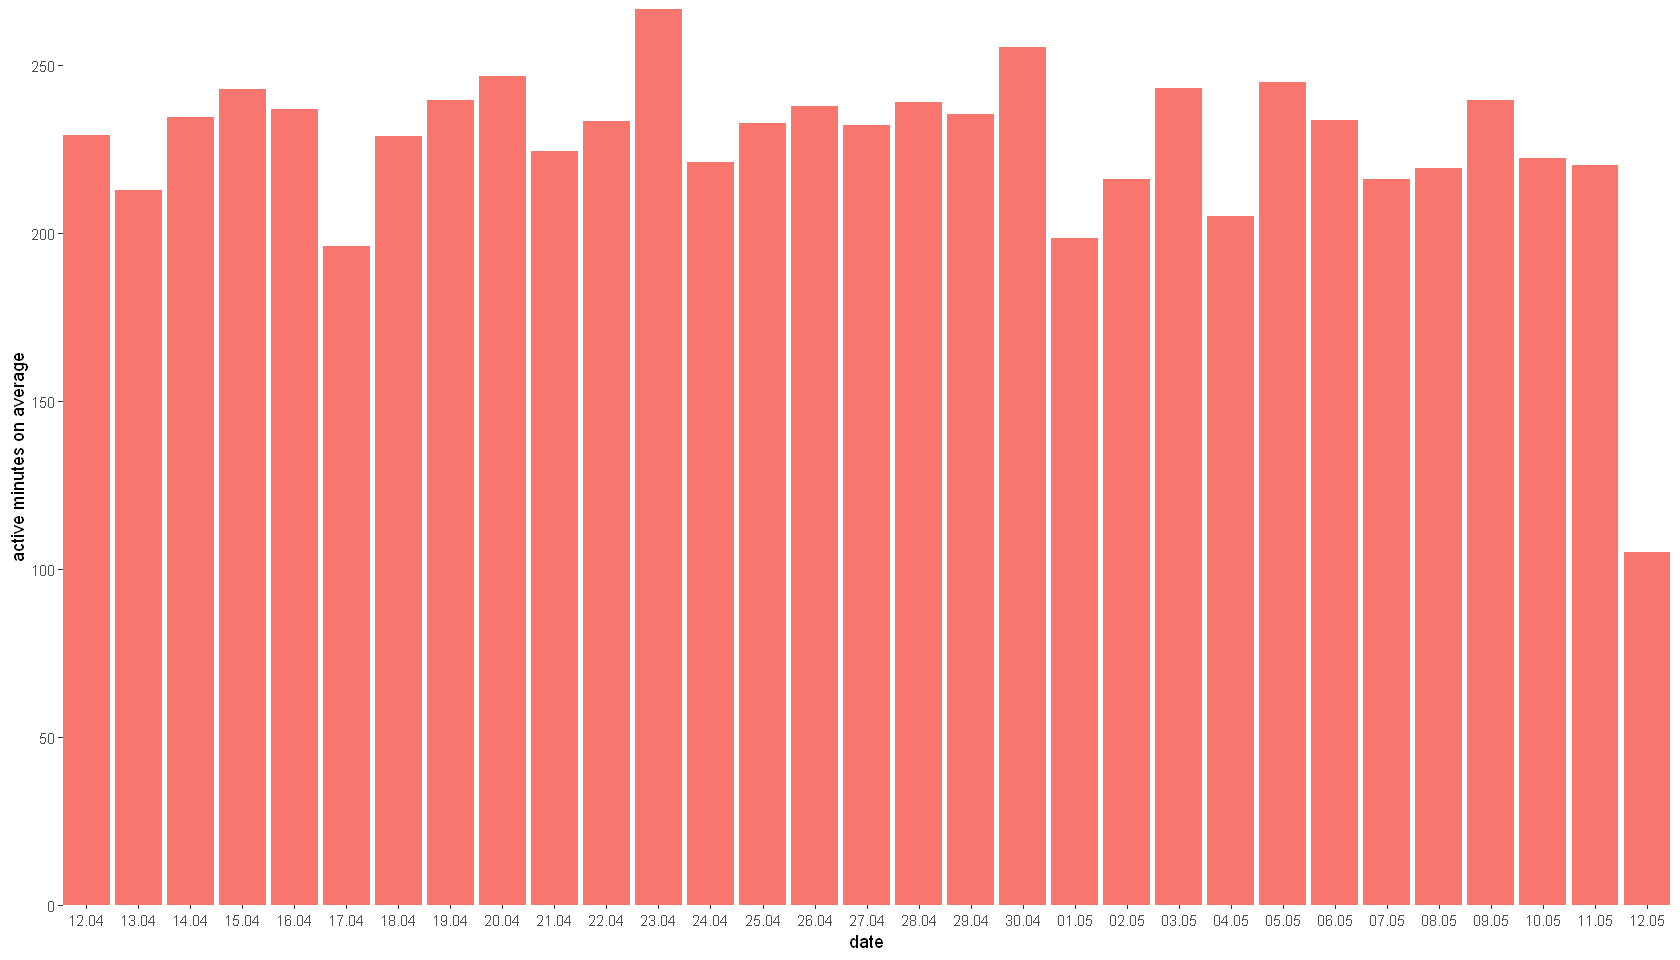

In [13]:
options(repr.plot.width=14, repr.plot.height=8)

daily_activity %>%
  group_by(date) %>%
  summarize(avg=mean(active_minutes)) %>%
  ggplot() +
  aes(x=date, y=avg, fill='#F8766D') +
  geom_col() +
  scale_y_continuous(expand=c(0,0)) +
  scale_x_date(breaks = '1 day', date_labels="%d.%m",
               expand=c(0,0)) +
  ylab('active minutes on average') +
  theme(legend.position="none",
        panel.background=element_blank(),panel.border=element_blank(),
        panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
        plot.background=element_blank())

Let's therefore remove all the data for 12.05 to not skew the results, as the average number of active minutes on that day is two times less than on the other days, and this is evidently not correct:

In [14]:
daily_activity <- daily_activity %>%
  filter(date!='2016-05-12')

daily_sleep <- daily_sleep %>%
  filter(date!='2016-05-12')

hourly_intensity <- hourly_intensity %>%
  filter(date!='2016-05-12')

hourly_steps <- hourly_steps %>%
  filter(date!='2016-05-12')

Finally, let's see how comprehensive and logical our data is:

In [ ]:
length(unique(daily_activity$id)) # all 33 people
length(unique(daily_sleep$id)) # 24 out of 33
length(unique(hourly_intensity$id)) # all 33 people
length(unique(hourly_steps$id)) # all 33 people

length(unique(daily_activity$date)) # all 30 days
length(unique(daily_sleep$date)) # all 30 days
length(unique(hourly_intensity$date)) # all 30 days
length(unique(hourly_steps$date)) # all 30 days

min(daily_activity$total_minutes) # 6 mins
max(daily_activity$total_minutes) # 1440 mins = 24 hours

Everything looks within the framework of what we expected.  
Additionally, we can see that 27% of participants were not interested at all in tracking sleep using devices.

## STEP 4. Visualizations

By this step, we have prepared our dataset for visualizing trends in __how consumers are using their smart devices.__  

To make consistent plots, let's create our own theme:

In [16]:
bellabeat_theme <- function() {
    
    ggplot2::theme(
    text = element_text(size = 14),
    axis.title = element_text(color = "black"),
    axis.text = element_text(color = "black"),
    plot.title = element_text(size = 16,
                              face = "bold",
                              color = "black",
                              vjust = 1,
                              hjust = 0.5),
    panel.grid.minor = element_blank(), 
    panel.grid.major = element_line(color = "#d0d0d0", linewidth=0.3),
    panel.background = element_blank(), panel.border = element_blank(),
    plot.background = element_blank(), legend.position = 'none')
    }

### Tracking Daily Activity

First, we want to see how the respondents use their smart devices when tracking daily activity (steps, active minutes, calories). We might suggest that this is one of the main features Bellabeat provides.

Let's plot how often (for how many days of the survey) users use the devices for tracking daily activities:

In [17]:
options(repr.plot.width=14, repr.plot.height=8)

count_activity <- daily_activity %>%
  group_by(id) %>%
  summarize(count = n_distinct(date))
  
a1 <- ggplot(count_activity) +
  aes(y=count, x=id, fill=id) + 
  geom_col() +
  geom_hline(yintercept=mean(count_activity$count), alpha=0.5) +
  scale_y_continuous(breaks = seq(0, 32, by = 2),expand=c(0,0)) +
  scale_x_discrete(expand=c(0,0)) +
  ylab('days registered') +
  xlab('users') +
  labs(title='Daily Activity Tracking Usage by User') +
  bellabeat_theme() +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(),
        panel.grid.major=element_blank())

In order to find out if there are any trends in user activity depending on the day of the week, let's plot how active the users are throughout the week using a density distribution plot to get a more comprehensive understanding of user behaviour:

In [18]:
wraps <- as_labeller(
  c('sedentary_minutes'='sedentary minutes', 'active_minutes'='active minutes'))

a2 <- daily_activity %>%
  tidyr::pivot_longer(active_minutes:sedentary_minutes, 
               names_to='minutes', values_to='result') %>%
  ggplot(aes(y=fct_rev(day), x=result, fill=day)) +
  geom_density_ridges(alpha=0.7,
                      quantile_lines=TRUE, quantile_fun=mean) +
  ylab('day of the week') +
  xlab('minutes registered') +
  labs(title='Active/Sedentary Minutes Registered by Day of the Week') +
  scale_x_continuous(breaks=seq(0,1500, by=200), expand=c(0,0)) +
  scale_y_discrete(expand=c(0,0)) +
  bellabeat_theme() +
  scale_fill_hue() +
  facet_wrap(vars(minutes), ncol = 2, labeller=wraps)

Let's now present the visualizations together:

Picking joint bandwidth of 39.1

Picking joint bandwidth of 100



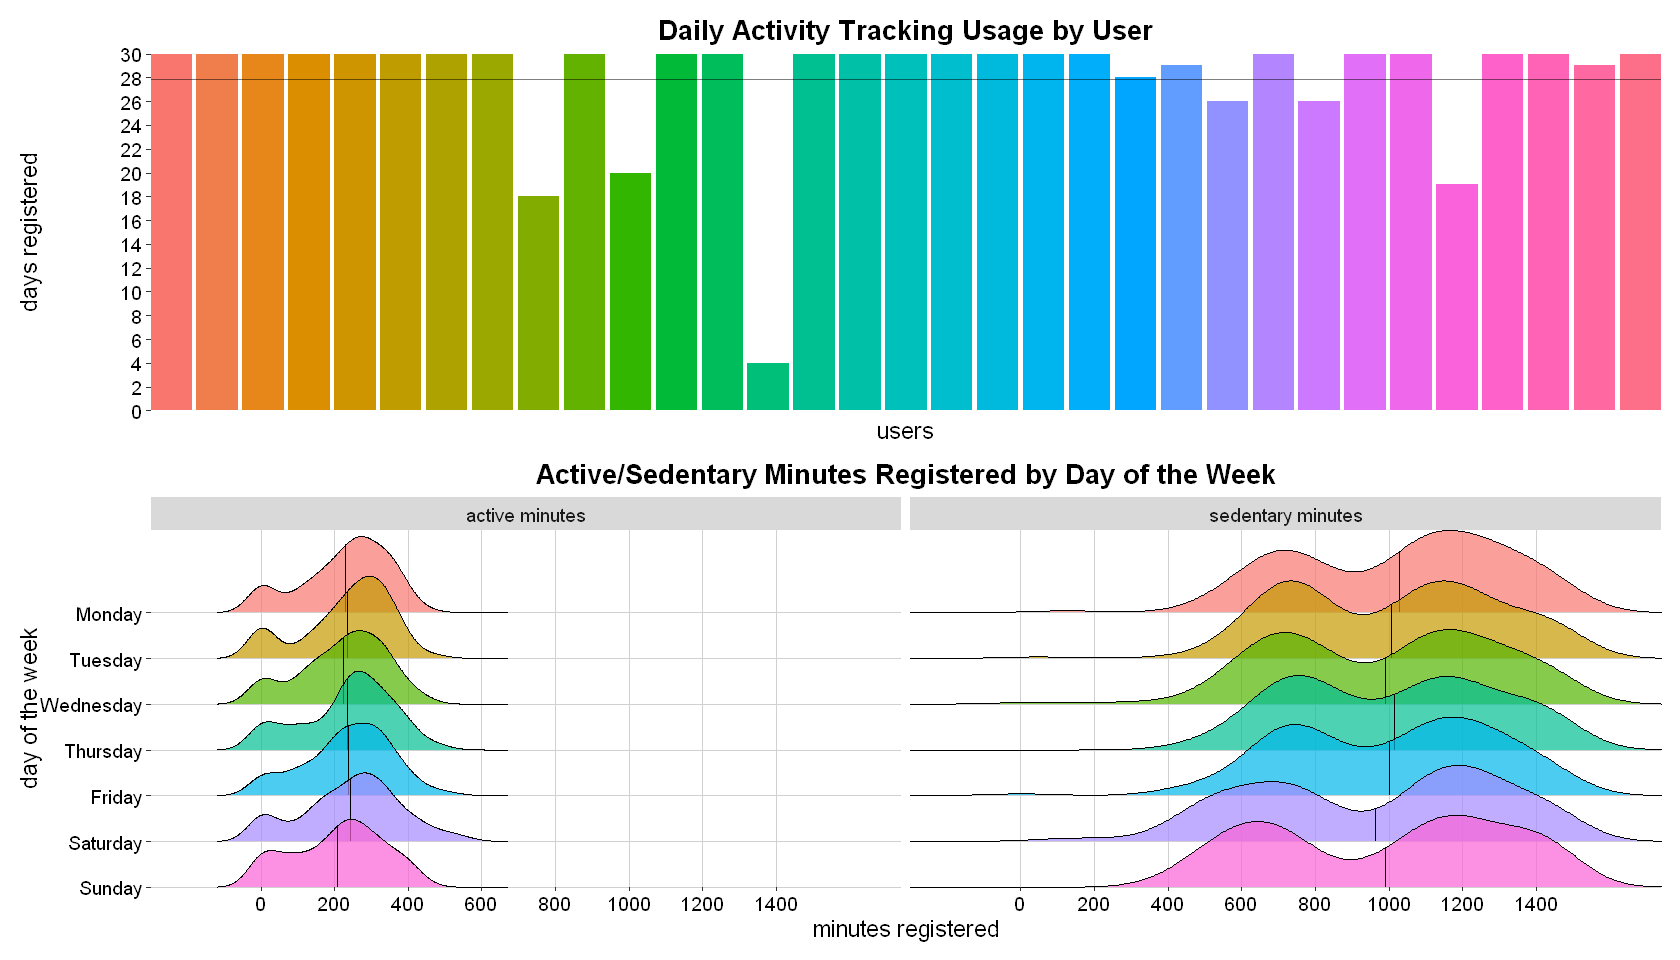

In [30]:
suppressWarnings(a1 / a2)

We can clearly see that the respondents are activly using their devices daily, with 28 days out of 30 being the average number of days registered per user. This could indicate __a high interest of users in tracking their daily activity, and Bellabeat can utilize it when marketing its products.__

In terms of active/seated minutes spent by users during the week, we don't see any clear trends. The average duration of activity is fairly constant and is about 4 hours, with an average of about 17 hours spent by users mostly sedentary. The numbers also tell us that on the average respondents use devices most of the day (~1200 minutes out of 1440).

### Tracking Steps

Another feature we can investigate is steps tracking.  

Let's first check for correlation between the number of steps and the calories burnt:

In [20]:
options(repr.plot.width=14, repr.plot.height=8)

st1 <- daily_activity %>%
  ggplot(aes(x=total_steps, y=calories)) + 
  geom_point(position = 'jitter', alpha=0.5) +
  geom_smooth(method="lm",se=FALSE, color='#F8766D') +
  xlab('number of steps') +
  ylab('calories burnt') +
  labs(title='Steps-Calories Relationship') +
  scale_y_continuous(breaks=seq(0,5000, by=500), labels = number_format(),
                     expand = c(0,0)) +
  scale_x_continuous(breaks=seq(0,25000, by=2500), labels = number_format(),
                     expand=c(0,0)) +
  coord_cartesian(xlim = c(0, 25000)) +
  stat_cor(p.accuracy = 0.001, r.accuracy = 0.01) +
  bellabeat_theme()

Then let's plot how the average number of steps is distributed throughout the day and throughout the week:

In [21]:
# steps taken during the day:

st2 <- hourly_steps %>%
  group_by(hour) %>%
  summarize(average = mean(step_total)) %>%
  ggplot() +
  aes(y=average, x=hour) + 
  geom_line(color='#F8766D') +
  ylab('steps on average') +
  xlab('hour') +
  labs(title='Average Number of Steps by Hour') +
  scale_x_continuous(breaks = seq(0,23, by=1), expand=c(0,0)) +
  scale_y_continuous(breaks = seq(0, 700, by = 100), expand=c(0,0)) +
  coord_cartesian(ylim = c(0, 700)) +
  bellabeat_theme()

# steps taken during the week:

average_steps <- daily_activity %>%
  group_by(day) %>%
  summarize(avg = mean(total_steps)) 

st3 <- ggplot(average_steps) +
  aes(y=avg, x=day, fill=day) +
  geom_col(width=0.8) +
  geom_hline(yintercept=mean(average_steps$avg), alpha=0.5) +
  scale_y_continuous(breaks=seq(0, 10000, by=1000), labels = number_format(),
                     expand=c(0,0)) +
  scale_x_discrete(expand=c(0,0)) +
  xlab('day of the week') +
  ylab('steps on average') +
  labs(title='Average Number of Steps by Day of the Week') +
  coord_cartesian(ylim = c(0, 10000)) +
  bellabeat_theme() +
  scale_fill_hue()

Let's now present the visualizations together:

`geom_smooth()` using formula = 'y ~ x'


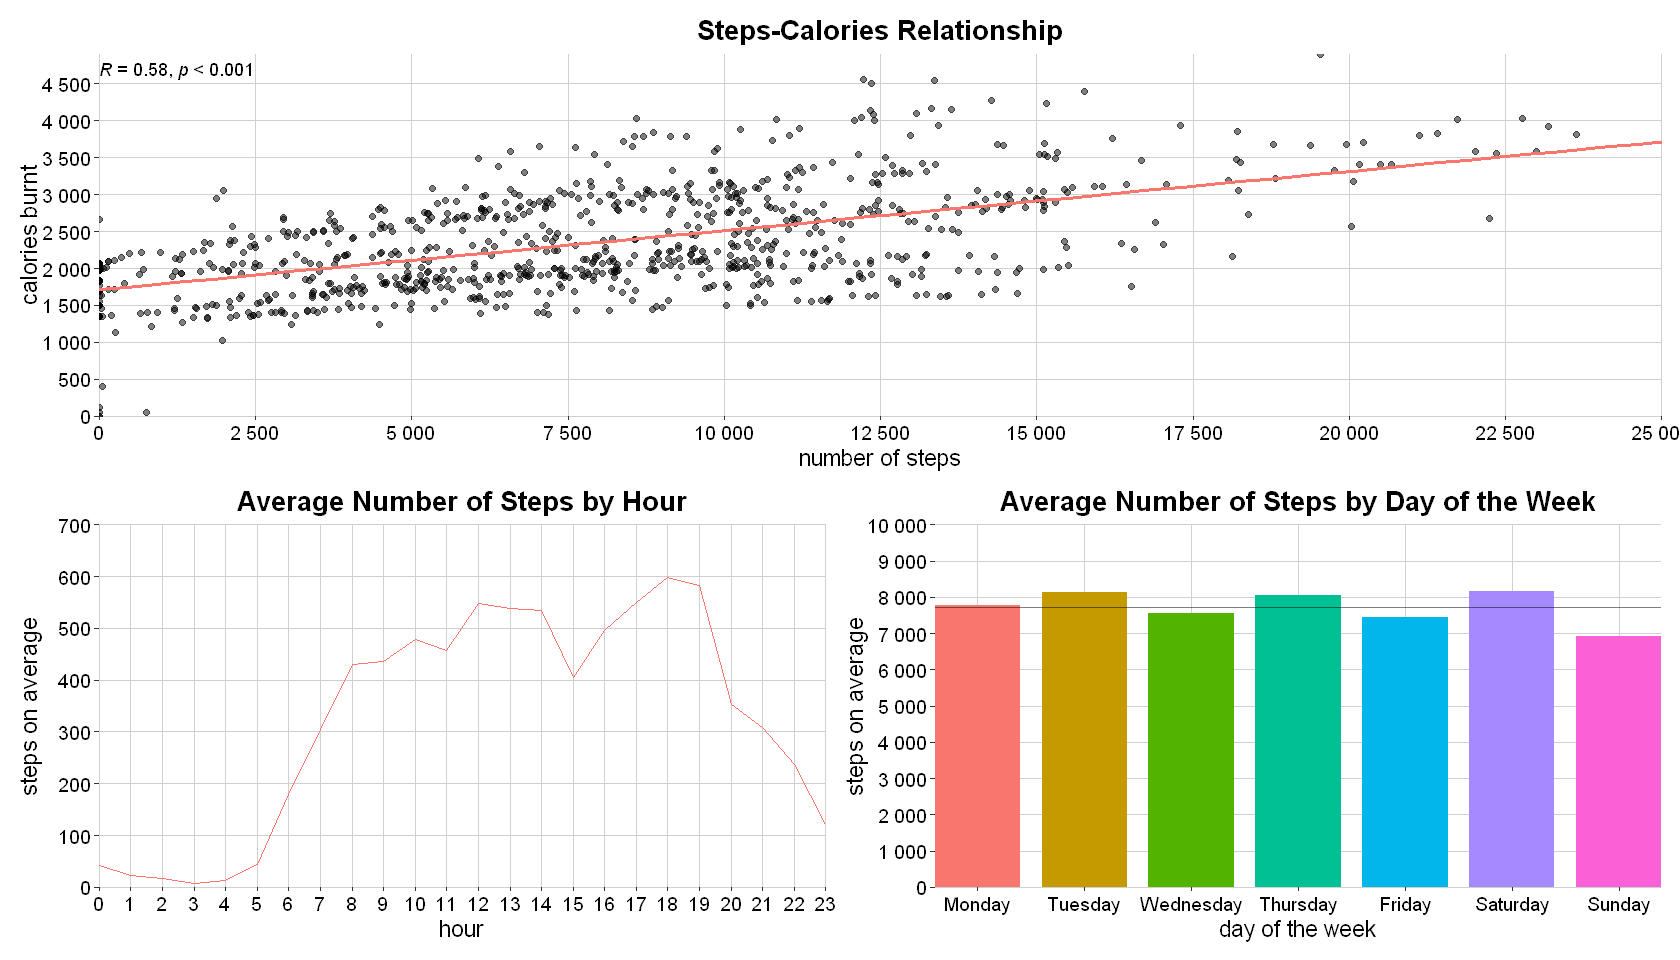

In [22]:
suppressWarnings(st1 / (st2 | st3))

First of all, we see the confirmation of the intuitive positive correlation between the number of steps and the calories burnt per day. This is a statistically significant correlation (p-value < 0.001).    
One interesting thing about this plot is that we see how many calories are burnt without taking any steps - around 1500 calories per day: it can be explained by trainings, completed and not accounted by the steps entries, intellectual activity, house activity, or just by the natural level of body's calorie expenditure.  
Another finding to mention here is that the positive correlation is rather moderate (as indicated by Pearson's correlation coefficient), leading us to conclude that __for the purposes of burning more calories (or weight loss), combining walking with more intense exercise is more effective.__

The average number of steps per hour hits its peak during the afternoon and evening hours, with nighttime logically being the least active period. 

The average number of steps during the week is fairly stable, with the least active walking day being Sunday. The company could use this information and __promote weekend walks to further improve the users' wellbeing.__  
Here we also see the overall average number of steps per day for the respondents - just under 8000 steps, which is a good level achievable through routine daily activities.

### Tracking Intensity

The next step of this analysis is to look at the intensity data, as it was believed to contain information on training intensity.    

Let's plot how the average level of training intensity is distributed throughout the day and throughout the week:

In [23]:
# intensity of trainings during the day:

options(repr.plot.width=14, repr.plot.height=4)

i1 <- hourly_intensity %>%
  group_by(hour) %>%
  summarize(average = mean(total_intensity)) %>%
  ggplot() +
  aes(y=average, x=hour) + 
  geom_line(color='#F8766D') +
  ylab('average intensity') +
  xlab('hour') +
  labs(title='Average Level of Intensity by Hour') +
  scale_x_continuous(breaks = seq(0,23, by=1), expand=c(0,0)) +
  scale_y_continuous(breaks = seq(0, 22, by = 2), expand=c(0,0)) +
  coord_cartesian(ylim = c(0, 23)) +
  bellabeat_theme()

# intensity of trainings during the week:

daily_intensity <- hourly_intensity %>%
  group_by(date, day, id) %>%
  summarize(daily_intensity = sum(total_intensity)) 

i2 <- daily_intensity %>%
  group_by(day) %>%
  summarize(avg = mean(daily_intensity)) %>%
  ggplot() +
  aes(y=avg, x=day, fill=day) +
  geom_col(width=0.8) +
  scale_y_continuous(breaks=seq(0, 350, by=50), labels = number_format(),
                     expand=c(0,0)) +
  scale_x_discrete(expand=c(0,0)) +
  xlab('day of the week') +
  ylab('average daily intensity') +
  labs(title='Average Intensity by Day of the Week') +
  coord_cartesian(ylim = c(0, 350)) +
  bellabeat_theme() +
  scale_fill_hue()

`summarise()` has grouped output by 'date', 'day'. You can override using the `.groups` argument.


Let's now present the visualizations together:

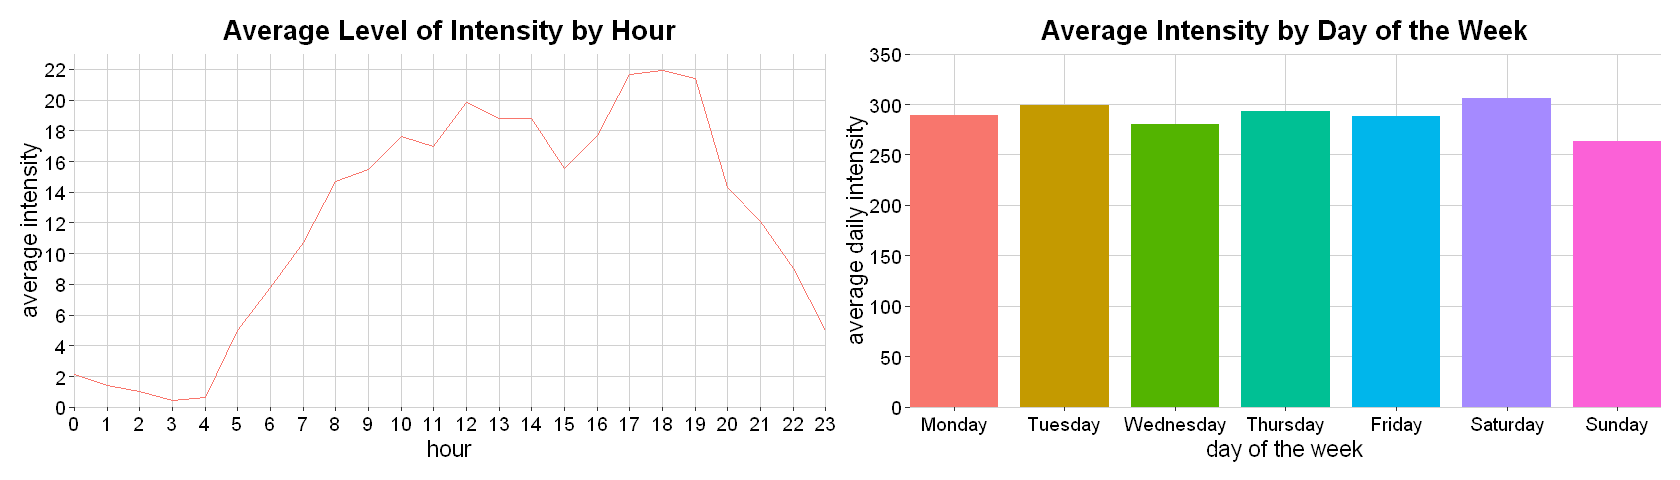

In [24]:
suppressWarnings(i1 | i2)

We might notice that visualizations on intensity and number of steps look suspiciously similar. Let's see them together once more:

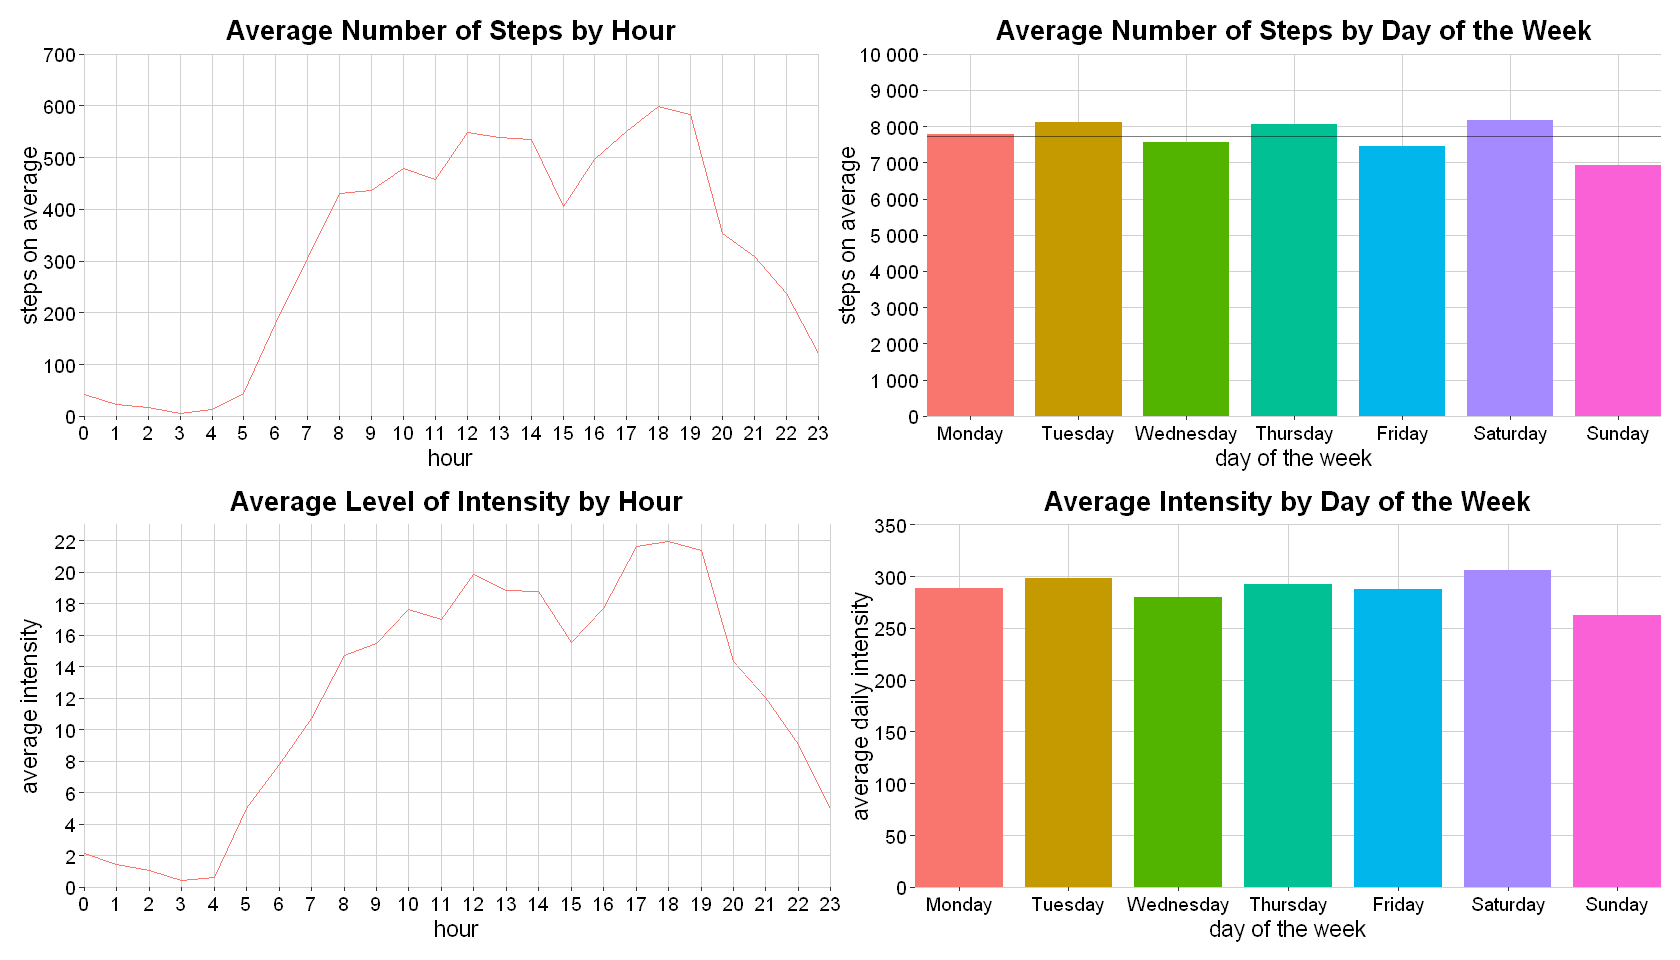

In [25]:
options(repr.plot.width=14, repr.plot.height=8)

(st2 | st3) / (i1 | i2)

Yes, it does look like the intensity in our dataset represented walking intensity (i.e., walking speed) and not training intensity.  
We might suggest that __the trainings tracking would be an additional feature Bellabeat might explore to better meet user needs in checking in with their activity.__

Since we found out that the number of steps alone does not strongly correlate to burning calories, our next hypothesis would be that the intensity of walking does.  
So, let's compare those relationships:

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


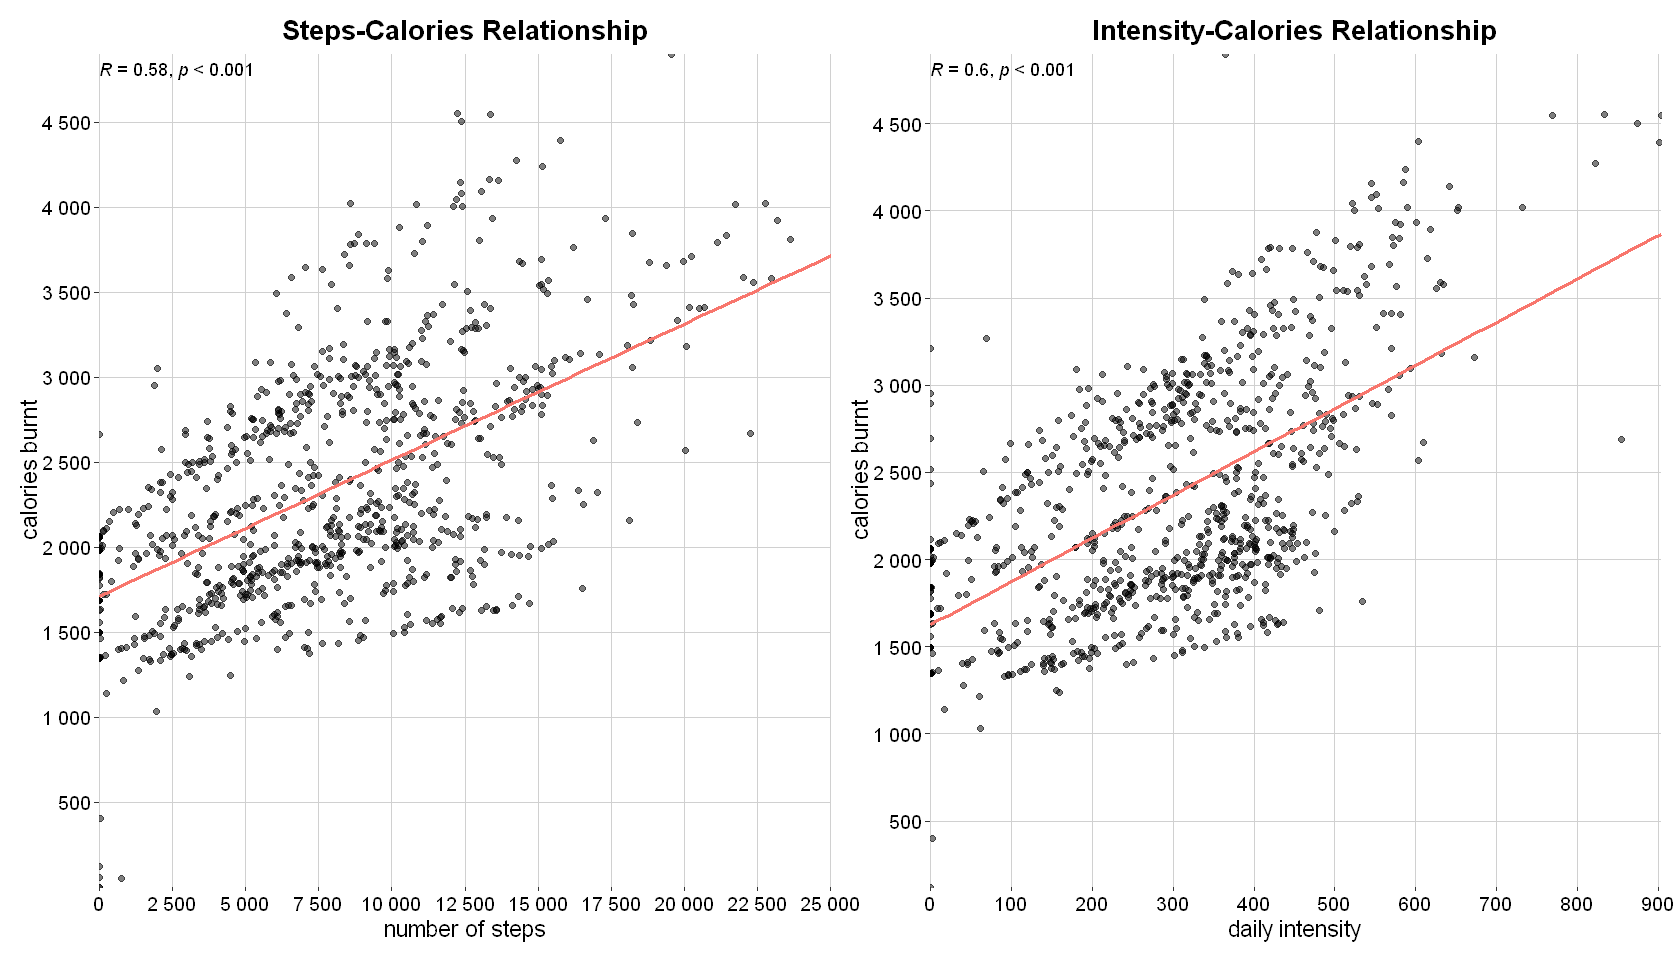

In [26]:
# first we merge two tables containing data on steps and intensity:

activity_intensity_merged <- merge(daily_intensity, daily_activity, on=id)

i3 <- activity_intensity_merged %>%
  ggplot(aes(x=daily_intensity, y=calories)) + 
  geom_point(position = 'jitter', alpha=0.5) +
  geom_smooth(method="lm",se=FALSE, color='#F8766D') +
  xlab('daily intensity') +
  ylab('calories burnt') +
  labs(title='Intensity-Calories Relationship') +
  scale_y_continuous(breaks=seq(0,5000, by=500), labels = number_format(),
                     expand = c(0,0)) +
  scale_x_continuous(breaks=seq(0,1000, by=100), labels = number_format(),
                     expand=c(0,0)) +
  stat_cor(p.accuracy = 0.001, r.accuracy = 0.01) +
  bellabeat_theme()

# now plot two graphs side by side:

st1 | i3

We see that the Pearson correlation coefficient is slightly higher in the case of intensity than the number of steps, indicating a bit stronger relationship between how fast people walk and how many calories they burn. Again, this gives us more insight into __how users can make the most of daily walk: for example, alternating between calm and more intense walks.__

### Tracking Sleep

Last but not least, the feature we want to explore is sleep tracking.  
As mentioned earlier, only 24 out of 33 survey participants tracked their sleep. Let's take a look at how often these users used their devices at night:

In [27]:
options(repr.plot.width=14, repr.plot.height=8)

count_sleep <- daily_sleep %>%
  group_by(id) %>%
  summarize(count = n_distinct(date))

sl1 <- ggplot(count_sleep) +
  aes(y=count, x=id, fill=id) + 
  geom_col() +
  geom_hline(yintercept=mean(count_sleep$count), alpha=0.5) +
  scale_y_continuous(breaks = seq(0, 30, by = 2),expand=c(0,0)) +
  scale_x_discrete(expand=c(0,0)) +
  ylab('nights registered') +
  xlab('users') +
  labs(title='Sleep Tracking Device Usage by User') +
  bellabeat_theme() +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(),
        panel.grid.major=element_blank())

Then we plot what the users' sleep patterns look like in general:

In [28]:
# hours of sleep by user:

average_sleep <- daily_sleep %>%
  group_by(id) %>%
  summarize(average_minutes=mean(total_minutes_asleep)) %>%
  mutate(average_hours = average_minutes / 60)
  
sl2 <- ggplot(average_sleep) +
  aes(y=average_hours, x=id, fill=id) + 
  geom_col() +
  geom_hline(yintercept=mean(average_sleep$average_hours), alpha=0.5) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_continuous(breaks=seq(0,11, by=1), expand=c(0,0)) +
  coord_cartesian(ylim = c(0, 11)) +
  xlab('users') +
  ylab('average number of hours of sleep') +
  labs(title='Hours of Sleep on Average by User') +
  bellabeat_theme() +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(),
        panel.grid.major=element_blank())

# hours of sleep throughout the week:

sl3 <- ggplot(daily_sleep, aes(y=fct_rev(day), x=total_minutes_asleep /60, fill=day)) +
  geom_density_ridges(alpha=0.7, 
                      quantile_lines=TRUE, quantile_fun=mean) +
  xlab('number of hours of sleep') +
  ylab('day of the week') +
  labs(title='Hours of Sleep by Day of the Week') +
  scale_x_continuous(breaks=seq(0,15, by=1), expand=c(0,0)) +
  scale_y_discrete(expand=c(0,0)) +
  bellabeat_theme() +
  scale_fill_hue()

Let's now present the visualizations together:

Picking joint bandwidth of 0.627



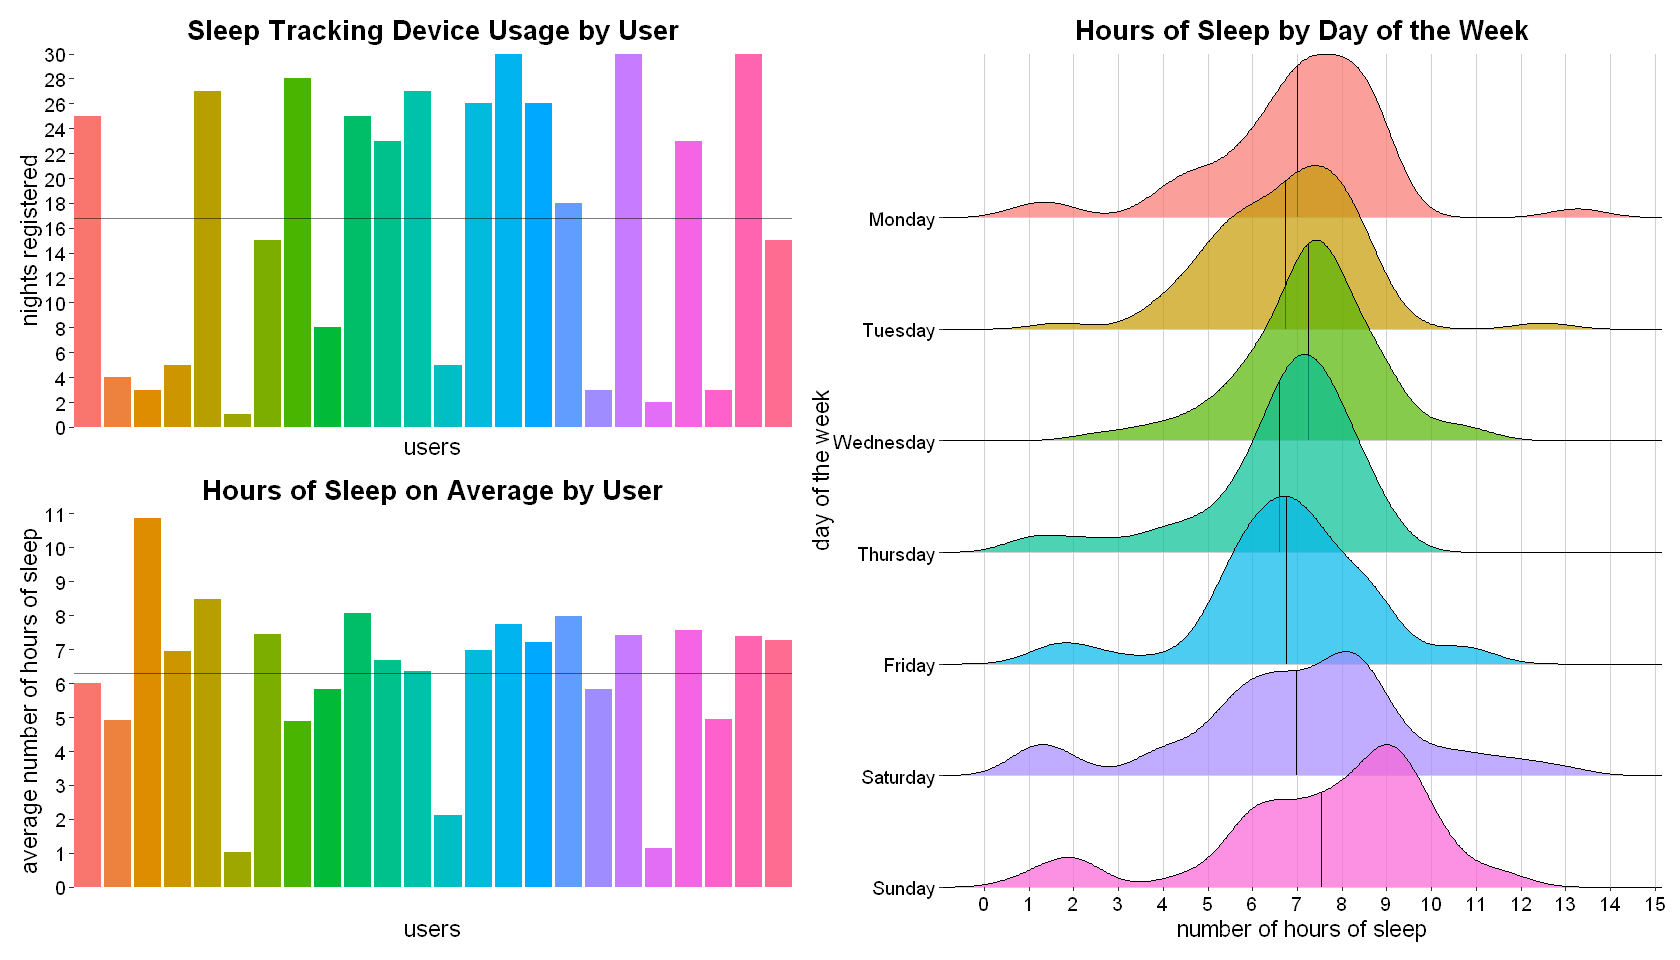

In [29]:
sl1 / sl2 | sl3

We can see that those users who chose to track their sleep did so only 57% of the nights on average. It highlights how underused this feature is, and __opens up opportunities for Bellabeat either not to support this feature to cut unnecessary costs, or to creatively engage users to add sleep tracking to their routine.__

In terms of hours of sleep, we see the users' average around 6-7 hours of sleep per night, which is not a concern but can be improved to a healthy standard of 8 hours of sleep.  
Moreover, as shown in the density distribution plot, some users are sleep deprived and sleep less than 4 hours per night. This would be another point for improvement.

On average, participants' sleep patterns don't fluctuate much during the week, with slightly more sleep on weekends than on weekdays. We can't draw any significant conclusions from that.

## End of Scenario, Recommendations

With the help of visualizations, we analyzed the trends and behavioural features of smart device users.

This analysis is based on open source Fitbit user data. We need to acknowledge the limitations of data, such as short period covered, small sample of participants, unknown sampling process that do not allow us to 100% guarantee unbiased and accurate conclusions. However, based on the data provided we can highlight some insights into how people use smart devices.  

Users have high interest in tracking their daily activity, they spend around 4 hours a day being active, which is not any different for the weekends.  
Users track their steps, walk more actively in the afternoon, averaging about 8,000 steps per day. Again, no significant difference was found for different days of the week. Users who walk more and (!) more intensively burn more calories.  
Only around 40% of participants' sleeps were tracked during the whole period of the survey. Users who provided any information slept an average of about 6-7 hours per night, and no vast difference was found across different days of the week.

Based on these findings, analytical team can suggest the following recommendations for the executive team to improve the marketing strategy in order to present Bellabeat devices more effectively:

- The company can encourage users to monitor their health and well-being daily and to move more using gamification methods.
- The company can engage users to walk more on weekends, as they don't seem to use the extra free time for outdoor activities.
- The company can offer users who want to lose weight to use walking as training by alternating between calm and intensive walks.
- The company can provide a feature of tracking training duration, intensity, calories burnt, etc.
- In order to cut expenses, the company can suspend development of functionality related to sleep tracking as it is found to be not of high interest to users.
- If the latter is not the case, Bellabeat can engage more users to track their sleep by gamification methods, more convenient devices (comfortable during sleep), emphasizing the importance of good sleep for maintaining and improving health, sending notifications in case of lack of sleep, etc.
- For more detailed recommendations analysts need to get access to more data: demographic (such as age, sex), longitudinal data - to better meet the long-term needs of different user groups.
- Another angle to look at the business task would be to offer more device or app features than presented in the dataset, such as: nutrition guides and food nutrient analysis, meal and water intake tracker, sugar level tracker and others. Additionally, since Bellabeat produces health-focused products for women, we could analyze data about the cycle or hormonal changes, track doctor visits, etc. to further improve women's wellbeing.

*The End. Let's all try to be mindful of our mental and physical health! :)*